# Correlation Variation vs m2 Prices and Segments Comparison

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
%matplotlib inline

### 1. Clustering of neighborhoods based on positive and negative cummulative variation of ratio regarding 2004

In [111]:
# Census cleaned and scaled data
variation_positive = pd.read_csv('variation_matrix_positive.csv', index_col=0)
variation_negative = pd.read_csv('variation_matrix_negative.csv', index_col=0)
variation = pd.concat([variation_positive, variation_negative],axis=1)

# Cost of m2 per district in Madrid at 2017 (source: Trovimap)
cost_m2 = pd.read_csv('cost_m2_districts_madrid_trovimap.csv', sep="\t")

In [84]:
# Cluster of ratio variation for each district into 3 groups
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=100, max_iter=100, random_state=32, algorithm='elkan')
labels = kmeans.fit_predict(variation)
results = pd.concat([pd.Series(variation.index.tolist()), pd.Series(labels.tolist())], 
                    axis=1).rename(columns={0:'district', 1:'cluster'})

In [112]:
correlation_variation_cost_m2 = cost_m2.merge(results, how='outer', right_on='district', left_on='district')

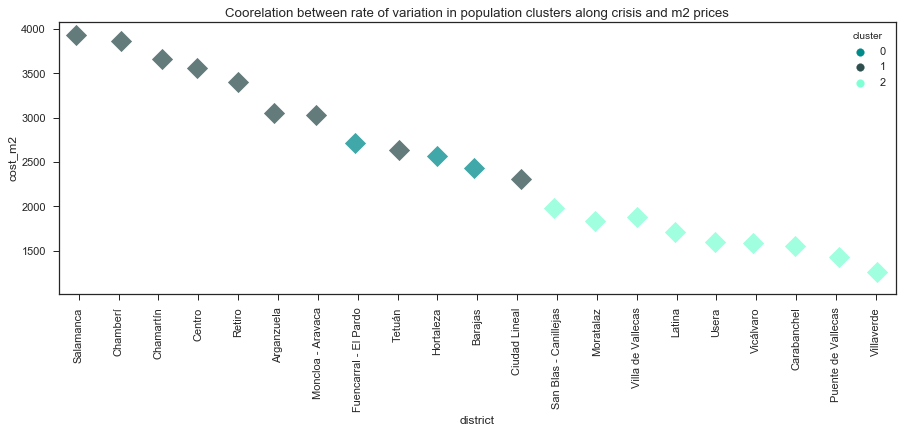

In [144]:
fig = plt.figure(figsize=(15,5))
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.set_palette(palette=['#008B8B','#2F4F4F','#7FFFD4'])

ax = sns.stripplot(x="district", y="cost_m2", hue="cluster", data=correlation_variation_cost_m2, 
                    size=15, marker="D", edgecolor="gray", alpha=.75, jitter=True)
ax.set_xticklabels(correlation_variation_cost_m2.district.tolist(), rotation=90)
ax.set_title("Coorelation between rate of variation in population clusters along crisis and m2 prices")
_ = ax.plot()

We can see in this plot that there is a clear coorelation between the effect of the crisis in the population levels and the price per m2. Districts with lower price per m2 have shown a higher variation in the population in the last years whereas higher price per m2 districts depict less impact.

There are two districts that are not correlated with the cluster label and the m2 price level and those are Tetuan and Ciudad Lineal. These two are still in the most expensive cluster.

### 2. Calculate percentages on variation per segments comparing Active/non-active population

In [114]:
# Parameters for aggregation by age range and segment
age_ranges = {'0-24': ['_0 - 4','_5 - 9','10 - 14','15 - 19','20 - 24'],
              '25-39': ['25 - 29','30 - 34','35 - 39'],
              '40-64': ['40 - 44','45 - 49','50 - 54','55 - 59','60 - 64'],
              '65-84': ['65 - 69','70 - 74','75 - 79','80 - 84'],
              '85-100': ['85 - 89','90 - 94','95 - 99','100 o más']}
segments = ['foreign_total', 'spanish_total', 'spanish_men', 'spanish_women']

In [115]:
def select_columns_with_string_pattern(list_columns, pattern):
    return [col for col in list_columns if pattern in col]
    
    
def select_columns_math_list_string_pattern(list_columns, list_patterns):
    return [col for col in list_columns if any(pat in col for pat in list_patterns)]    
    

def aggregate_by_age_ranges(data, age_ranges, segments):
    data_ = data.copy()
    scaler = MinMaxScaler(feature_range=(0,10))
    
    # select segments
    selected_columns_a = select_columns_with_string_pattern(data.columns.tolist(), segments[0])
    selected_columns_b = select_columns_with_string_pattern(data.columns.tolist(), segments[1])
    selected_columns_c = select_columns_with_string_pattern(data.columns.tolist(), segments[2])
    selected_columns_d = select_columns_with_string_pattern(data.columns.tolist(), segments[3])
    data_a = data_.loc[:, selected_columns_a]
    data_b = data_.loc[:, selected_columns_b]
    data_c = data_.loc[:, selected_columns_c]
    data_d = data_.loc[:, selected_columns_d]
    
    # aggregate by age ranges
    agg_a = []
    agg_b = []
    agg_c = []
    agg_d = []
    age_range_keys = list(age_ranges.keys())
    age_range_values = list(age_ranges.values())
    for i in range(len(age_ranges)):
        # select all columns that contain that age range
        selected_columns_a = select_columns_math_list_string_pattern(data_a.columns.tolist(), age_range_values[i])
        selected_columns_b = select_columns_math_list_string_pattern(data_b.columns.tolist(), age_range_values[i])
        selected_columns_c = select_columns_math_list_string_pattern(data_c.columns.tolist(), age_range_values[i])
        selected_columns_d = select_columns_math_list_string_pattern(data_d.columns.tolist(), age_range_values[i])
        
        # aggregate within the age_range by obt
        segment_age_a = data_a.loc[:,selected_columns_a].median(axis=1)
        segment_age_b = data_b.loc[:,selected_columns_b].median(axis=1)
        segment_age_c = data_c.loc[:,selected_columns_c].median(axis=1)
        segment_age_d = data_d.loc[:,selected_columns_d].median(axis=1)
        
        agg_a.append(pd.DataFrame(segment_age_a, index=segment_age_a.index.tolist(), columns=[age_range_keys[i]]))
        agg_b.append(pd.DataFrame(segment_age_b, index=segment_age_a.index.tolist(), columns=[age_range_keys[i]]))
        agg_c.append(pd.DataFrame(segment_age_c, index=segment_age_a.index.tolist(), columns=[age_range_keys[i]]))
        agg_d.append(pd.DataFrame(segment_age_d, index=segment_age_a.index.tolist(), columns=[age_range_keys[i]]))
        
    return pd.concat(agg_a, axis=1).reset_index(), pd.concat(agg_b, axis=1).reset_index(), pd.concat(agg_c, axis=1).reset_index(), pd.concat(agg_d, axis=1).reset_index()

In [116]:
var_positive_foreign, var_positive_spanish, var_negative_men, var_negative_women = aggregate_by_age_ranges(variation_positive, age_ranges, segments)
var_negative_foreign, var_negative_spanish,  var_negative_men, var_negative_women = aggregate_by_age_ranges(variation_negative, age_ranges, segments)

#### 2.1. Compare variation in ratio per segments for each cluster

In [133]:
# Classify districts based on the prices of m2
high_districts = correlation_variation_cost_m2[correlation_variation_cost_m2['cluster'] == 1]['district'].tolist()
middle_districts = correlation_variation_cost_m2[correlation_variation_cost_m2['cluster'] == 0]['district'].tolist()
low_districts = correlation_variation_cost_m2[correlation_variation_cost_m2['cluster'] == 2]['district'].tolist()

In [ ]:
def calculate_percentage_difference(semgment_a, segment_b, district_a, district_b):
    # Calculate median for districts in given cluster for each age range
    select_a = segment_a[segment_a['index'].isin(district_a)]
    select_b = segment_b[segment_b['index'].isin(district_b)]
    
    medians_a = []
    medians_b = []
    for age in semgment_a.columns.tolist()[1:]:
        # make all values positive by arbitrarily sum 5 and the differences are always between positive numbers
        medians_a.append(select_a[age].median() + 5)
        medians_b.append(select_b[age].median() + 5)
        
    # Calculate difference between medians for each age range
    diff_medians = np.asarray(medians_b, dtype=np.float32) - np.asarray(medians_a, dtype=np.float32)
    
    # Calculate percentage of variation with respect to reference
    variation_percent = diff_medians / np.asarray(medians_a, dtype=np.float32) * 100
    
    return variation_percent

In [134]:
# Percentage of decrease of people in poor with respect to the rich for spanish in all age segments

# Percentage of increase of people in poor with respect to the rich for spanish in all age segments

# Percentage of decrease of women in poor with respect to the rich for women in all age segments

# Percentage of increase of men in poor with respect to the rich for men in all age segments

# Percentage of increase of poor foreign people with respect to foreign rich people in all age segments

# Percentage of decrease of poor foreign people with respect to foreign rich people in all age segments

# Percentage of increase of poor spanish people with respect to foreign poor people in all age segments

# Percentage of decrease of poor spanish people with respect to foreign poor people in all age segments



,index,0-24,25-39,40-64,65-84,85-100
0,Arganzuela,-1.476973,-0.157687,1.113612,-0.314847,0.665943
1,Barajas,-0.454459,0.033871,0.755672,0.485769,-1.285914
2,Carabanchel,-0.216905,0.191634,1.385593,0.365418,0.089019
3,Centro,-0.896985,-0.188250,1.446285,0.420413,-0.631064
4,Chamartín,-0.895969,0.329624,1.080724,-0.377748,-0.800216
5,Chamberí,-0.882534,0.035390,1.012235,-0.298766,-0.372183
6,Ciudad Lineal,-0.636529,0.200985,1.213689,-0.228002,0.546785
7,Fuencarral - El Pardo,-0.853667,0.658540,0.765196,-0.056331,-0.735437
8,Hortaleza,-0.402826,0.586448,0.924428,0.981269,-0.860117
9,Latina,-0.198423,0.371142,1.640941,0.749518,-0.946857


In [146]:
a = np.asarray([1.,3.4,4.,6.], dtype=np.float32)
b = np.asarray([2.,1.,5.,6.], dtype=np.float32)
a - b

array([-1.       ,  2.4000001, -1.       ,  0.       ], dtype=float32)